In [26]:
import pandas as pd
import numpy as np

In [27]:
!ls ../input/titanic

gender_submission.csv  test.csv  train.csv


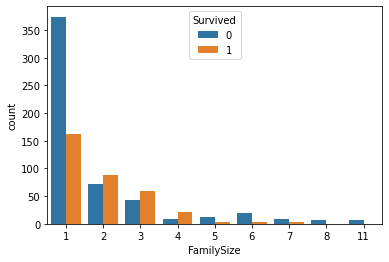

In [30]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')
data = pd.concat([train, test], sort = False )
# visualize
import seaborn as sns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x = 'FamilySize', data = train, hue = 'Survived')
# create newfeatures
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
# data.loc[True or False, columns] = 1となる
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]
#train.head()
# is ?
data['Sex'].replace(['male', 'female'],[0,1],inplace =True)
data['Embarked'].str.contains('S').sum()
data['Embarked'].str.contains('C').sum()
data['Embarked'].str.contains('Q').sum()
data['Embarked'].fillna(('Q'), inplace = True)
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2 }).astype(int)
data['Fare'].fillna(np.mean(data['Fare']), inplace = True)
data['Age'].fillna(data['Age'].median(), inplace=True)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis = 1, inplace = True)
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)
# LightGBM is necessary for
# dataset split
# category variable is listed
# This is easy to be overlearning 
# The way to solve this is "early stopping"
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0, stratify = y_train)
# stratify 層別化する
# stratify = y_test で結果データの値の比率が一致するようになる
# category
categorical_features = ['Embarked', 'Pclass', 'Sex']

In [23]:
# param-adjust
# hand-powered ? Tuning tool


# Use large max_bin (may be slower)

# Use small learning_rate with large num_iterations

# Use large num_leaves (may cause over-fitting)

# Use bigger training data

# Try dart

# split and category is over, then execute LightGBM
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature = categorical_features)
# reference = should be same bins in training and validation

# -- change below

params = {
    'objective':'binary',
    'max_bin':300,
    'learning_rate':0.05,
    'num_leaves':40
}

# make model
model = lgb.train(params, lgb_train, 
                valid_sets = [lgb_train, lgb_eval],
                verbose_eval=10,
                num_boost_round = 10000,
                early_stopping_rounds = 10)
y_pred = model.predict(X_test, num_iteration = model.best_iteration)

Training until validation scores don't improve for 10 rounds
[5]	training's l2: 0.160093	valid_1's l2: 0.173589
[10]	training's l2: 0.129542	valid_1's l2: 0.154315
[15]	training's l2: 0.114757	valid_1's l2: 0.145461
[20]	training's l2: 0.104983	valid_1's l2: 0.140046
[25]	training's l2: 0.0967788	valid_1's l2: 0.135637
[30]	training's l2: 0.0900123	valid_1's l2: 0.13638
[35]	training's l2: 0.0846868	valid_1's l2: 0.135978
Early stopping, best iteration is:
[26]	training's l2: 0.0948357	valid_1's l2: 0.135195


In [24]:
# determine thresh's value y_pred > 0.5 ? 1 : 0
y_pred = (y_pred > 0.5).astype(int)

In [25]:
sub = gender_submission
sub['Survived'] = list(map(int, y_pred))
sub.to_csv('submission.csv', index=False)